## Import and Preprocessing

In [ ]:
!pip install nltk
! pip install nltk
! pip install yellowbrick
! pip install umap-learn
! pip install plotly
! pip install transformers
! pip install pyLDAvis
! pip install pyyaml==5.4.1
! pip install tensorflow tensorflow_hub
seed=42

  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from shutil import copyfile
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.metrics import (rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score, fowlkes_mallows_score, silhouette_score)
import tensorflow as tf
import tensorflow_hub as hub
from bs4 import BeautifulSoup

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab') # This is specifically needed to address the LookupError

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_da

True

In [ ]:
from google.colab import drive
import shutil  # Per copiare i file

# Monta Google Drive
drive.mount('/content/gdrive')

# Percorso al file sorgente in Google Drive
#source_path = '/content/gdrive/My Drive/Colab Notebooks/yelp_dataset/pre_processed.csv'
#source_path = '/content/gdrive/MyDrive/yelp_dataset/pre_processed.csv'
source_path = '/content/gdrive/MyDrive/StackOverflow dataset/train.csv'

# Percorso al file di destinazione nel file system di Colab
destination_path = '/content/train.csv'

# Copia il file dal Drive al file system locale
shutil.copyfile(source_path, destination_path)

print(f"File copiato con successo in {destination_path}")



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File copiato con successo in /content/train.csv


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Carica il dataset
file_path = "train.csv"
data = pd.read_csv(file_path)
data.shape

(45000, 6)

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    sub_pattern = r'[^A-Za-z]'
    split_pattern = r"\s+"
    #remove stop words
    stop_words = stopwords.words('english') + ['never','ever','couldnot','wouldnot','could','would','us',"i'm","you'd"]
    text = BeautifulSoup(text, "html.parser").get_text()
    lower_text = text.lower()                                              # Converting all words into lower case.
    filtered_text = re.sub(sub_pattern,' ',lower_text).lstrip().rstrip()   # Replacing all characters except those in the pattern into spaces.
    filtered_text = word_tokenize(filtered_text)                            # tokenizethe whole book into words in a list.
    filtered_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_text if word not in stop_words]
    #return filtered_text
    return ' '.join(filtered_text)

def normalize_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered_tokens)

In [ ]:
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [ ]:
def transform_tags(tags):
    return tags.strip('<>').split('><')

data['Tags_array'] = data['Tags'].apply(transform_tags)
data['Tags_array'] = data['Tags_array'].apply(lambda x: x[0] if len(x) > 0 else None)

In [ ]:
dataset = pd.DataFrame()
dataset['text'] = data['Body']
dataset['tags'] = data['Tags_array']
dataset.head()

,text,tags
0,<p>I'm already familiar with repeating tasks e...,java
1,<p>I'd like to understand why Java 8 Optionals...,java
2,<p>I am attempting to overlay a title over an ...,javascript
3,"<p>The question is very simple, but I just cou...",swift
4,<p>I'm using custom floatingactionmenu. I need...,android


In [ ]:
sample_size = 5000
dataset_sampled = dataset.sample(n=sample_size, random_state=42)
print(dataset_sampled.shape)

(5000, 2)


In [ ]:
dataset_sampled['cleaned_text'] = dataset_sampled['text'].apply(lambda x: clean_text(x))
dataset_sampled['normalized_text'] = dataset_sampled['text'].apply(lambda x: normalize_text(x))

<ipython-input-6-b5233a675161>:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)
<ipython-input-6-b5233a675161>:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
/usr/lib/pyth

In [ ]:
print(dataset_sampled[['text', 'cleaned_text', 'normalized_text']].head(3))

                                                    text  \
37979  <p>I'am not able to run a function in php oops...   
9911   <p>I have looked into the forum, but with no l...   
43386  8.\tThe sales director would like to reward th...   

                                            cleaned_text  \
37979  able run function php oops concept data get in...   
9911   look forum luck requirement run git log format...   
43386  sale director like reward employee net sale ye...   

                                         normalized_text  
37979  able run function php oops concept data gets i...  
9911   looked forum luck requirement run git log form...  
43386  sales director would like reward employees net...  


## Bag of Word

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
BOW = CountVectorizer()
BOW_transformation = BOW.fit_transform(dataset_sampled['cleaned_text'])

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_ngram(n_gram,X_train=dataset_sampled['cleaned_text']):
    vectorizer = TfidfVectorizer(ngram_range=(n_gram,n_gram))
    x_train_vec = vectorizer.fit_transform(X_train)
    return x_train_vec

In [ ]:
# Applying tfidf with 1-gram, and 2-gram
tfidf_1g_transformation= tfidf_ngram(1,X_train=dataset_sampled['cleaned_text'])
tfidf_2g_transformation= tfidf_ngram(2,X_train=dataset_sampled['cleaned_text'])

## Doc2Vec

In [ ]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
# Tokenization of each document
tokenized_doc = []
for d in dataset_sampled['normalized_text']:
    tokenized_doc.append(word_tokenize(d.lower()))

# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data[0]

TaggedDocument(words=['able', 'run', 'function', 'php', 'oops', 'concept', 'data', 'gets', 'inserted', 'without', 'checking', 'validation', 'code', 'form', 'directly', 'points', 'function', 'function', 'error', 'balance', 'id', 'amount', 'greater', 'pay', 'amount', 'br', 'else', 'balance', 'penalty', 'balance', 'zero', 'penalty', 'applied', 'error', 'error', 'header', 'location', 'function', 'rest', 'insertion', 'code'], tags=[0])

In [ ]:
# Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=50, window=2, min_count=1, workers=4, epochs = 100)

In [ ]:
def get_doc2vec_vector(df):
    doc2vec_vectors=[]
    for sentence in dataset_sampled['normalized_text']:
        doc2vec_vectors.append(model.infer_vector(word_tokenize(sentence.lower())))
    return doc2vec_vectors
doc2vec_vectors=get_doc2vec_vector(dataset_sampled['normalized_text'])
len(doc2vec_vectors)

5000

## Bert

In [ ]:
!pip install transformers

In [ ]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Check the GPU
import torch
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Import Libraries
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel
from keras_preprocessing.sequence import pad_sequences
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create sentence and label lists
sentences = dataset_sampled['normalized_text'].values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize the sentences and put them in the list tokenized_texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
hidden_states=[]
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
# Conver the ids into a tensor representation
batch_size = 4
input_tensor = torch.tensor(input_ids)
masks_tensor = torch.tensor(attention_masks)
train_data = TensorDataset(input_tensor, masks_tensor)
dataloader = DataLoader(train_data, batch_size=batch_size)
# Initialize the model
if torch.cuda.is_available():
    model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cuda')
else:
    model = BertModel.from_pretrained("bert-base-uncased",output_hidden_states = True,).to('cpu')
model.eval()
outputs = []

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
for input, masks in dataloader:
    torch.cuda.empty_cache() # empty the gpu memory
    # Transfer the batch to gp
    if torch.cuda.is_available():
        input = input.to('cuda')
        masks = masks.to('cuda')
    # Run inference on the batch
    output = model(input, attention_mask=masks)
    # Transfer the output to CPU again and convert to numpy
    output = output[0].cpu().detach().numpy()
    # Store the output in a list
    outputs.append(output)
# Concatenate all the lists within the list into one list
outputs = [x for y in outputs for x in y]

In [ ]:
bert_vectors=np.array(outputs)
bert_vectors=bert_vectors.mean(axis=1)
bert_vectors.shape

(5000, 768)

## Glove

In [ ]:
import gensim.downloader as api
def get_vectors_pretrained(df, model):
    embedding_vectors = []
    for partition in df['cleaned_text']:
        sentence = []
        for word in partition.split(' '):
            try:
                sentence.append(model[word])
            except:
                pass
        sentence = np.array(sentence)
        sentence = sentence.mean(axis=0)
        embedding_vectors.append(sentence)
    embedding_vectors = np.array(embedding_vectors)
    return embedding_vectors

In [ ]:
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-300")
glove_vectors=get_vectors_pretrained(dataset_sampled,glove_model)
glove_vectors

[==================================================] 100.0% 376.1/376.1MB downloaded


array([[-0.24440818,  0.08271283, -0.01571345, ..., -0.14453873,
         0.00034894, -0.22194162],
       [-0.25686207,  0.04011676,  0.0497129 , ..., -0.15498346,
         0.04703635, -0.04257821],
       [-0.21610153,  0.22921365, -0.05584282, ..., -0.14447682,
         0.04181111, -0.11569982],
       ...,
       [-0.09126988,  0.01630139, -0.05824905, ..., -0.18722245,
         0.03413623,  0.00106123],
       [-0.24343719,  0.03675872, -0.01661328, ..., -0.26057956,
         0.07313868, -0.13994373],
       [-0.16487852,  0.06223795, -0.03373246, ..., -0.10869895,
        -0.01880068,  0.04554305]], dtype=float32)

## FastText

In [ ]:
dt = pd.DataFrame()
dt = dataset_sampled[['cleaned_text', 'tags']]

import gensim.downloader as api
fast_text_model = api.load("fasttext-wiki-news-subwords-300")
fast_text_vectors=get_vectors_pretrained(dt,fast_text_model)
fast_text_vectors.shape

[==================================================] 100.0% 958.5/958.4MB downloaded


(5000, 300)

## Word2Vec

In [ ]:
#import gensim.downloader as api
#word2vec_model = api.load("word2vec-google-news-300")  # load glove vectors
#word2vec_vectors = get_vectors_pretrained(dataset_sampled,word2vec_model)
#word2vec_vectors

## LDA (Latent Dirichlet Allocation)

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import gensim

paragraphs = dataset_sampled['cleaned_text'].to_list()
docs = []

for sen in paragraphs:
    docs.append(list(sen.split()))
print(len(docs))

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.8)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(len(corpus[2]))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

5000
47
Number of unique tokens: 1377
Number of documents: 5000


In [ ]:
# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
#print(len(dictionary))
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.9810.


In [ ]:
all_topics = model.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
lda_to_cluster = all_topics_csr.T.toarray()
lda_to_cluster.shape

(5000, 5)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
## Evaluating coherence of gensim LDA model
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence_score = cm.get_coherence()
print(coherence_score)

-1.9809689253816618


## Embedding dictionary

In [ ]:
text_embedding={
    'BOW':BOW_transformation.toarray(),
    'TF_IDF 1_gram':tfidf_1g_transformation.toarray(),
    'Doc2vec':np.array(doc2vec_vectors),
    'Glove':glove_vectors,
    'FastText':fast_text_vectors,
    #'Word2vec':word2vec_vectors,
    'BERT':bert_vectors,
    'LDA':lda_to_cluster,
}

In [ ]:
import pickle
a_file = open("EmbeddingText_edited.pkl", "wb")
pickle.dump(text_embedding, a_file)
a_file.close()
print('Saved')

Saved


## Word Embedding Visualization

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
pca=PCA(n_components=3,)
embedding=text_embedding.copy()

for key in embedding.keys():
  embedding[key]=pca.fit_transform(embedding[key])
  df=pd.DataFrame({'PCA1':embedding[key][:,0],'PCA2':embedding[key][:,1],'PCA3':embedding[key][:,2],'Target':np.zeros(5000)})
  fig = px.scatter_3d(data_frame =df, x='PCA1', y='PCA2', z ='PCA3', color='Target')
  fig.update_layout(title={'text':f'{key}','x':0.5},height=500,width=700)
  fig.show()

## Bert GABRI

In [ ]:
# Embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
embedding = model.encode(data['processed_text'])

## Clustering

In [ ]:
# Clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


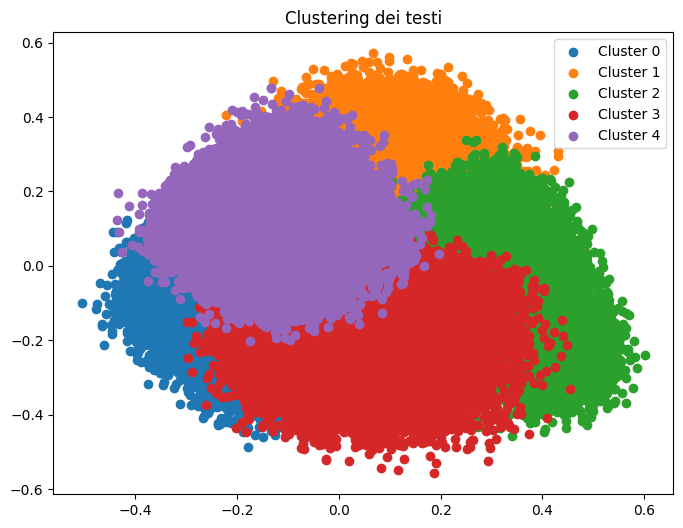

In [ ]:
# Visualizzazione (riduzione dimensionale con PCA)
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(embedding_2d[cluster_labels == i, 0], embedding_2d[cluster_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title("Clustering dei testi")
plt.show()

In [ ]:
def score_clustering(true_labels, predicted_labels, embedding):
  d = {
      "Rand index": rand_score(true_labels, predicted_labels),
      "Adjusted Mutual Info": adjusted_mutual_info_score(true_labels, predicted_labels),
      "Homogeneity": homogeneity_score(true_labels, predicted_labels),
      "Completeness": completeness_score(true_labels, predicted_labels),
      "V measure": v_measure_score(true_labels, predicted_labels),
      "Fowlkes Mallows": fowlkes_mallows_score(true_labels, predicted_labels),
      "Silhoutte": silhouette_score(embedding, predicted_labels)
  }
  for k, v in d.items():
    print(f"{k:21s}: {v}")

In [ ]:
array = np.array(data["stars_x"])
ground_truth = array.astype(int)
type(ground_truth)

numpy.ndarray

In [ ]:
score_clustering(ground_truth, cluster_labels, embedding)

Rand index           : 0.6395525471254713
Adjusted Mutual Info : 0.07286153687216053
Homogeneity          : 0.07805384448550193
Completeness         : 0.0684040734835067
V measure            : 0.07291105851970782
Fowlkes Mallows      : 0.280026867464782
Silhoutte            : 0.016124187037348747


In [ ]:
n_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = agg_clustering.fit_predict(embedding)

MemoryError: unable to allocate array data.

In [ ]:
# Visualizzazione (riduzione dimensionale con PCA)
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(embedding_2d[cluster_labels == i, 0], embedding_2d[cluster_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title("Clustering dei testi")
plt.show()

In [ ]:
score_clustering(ground_truth, cluster_labels, embedding)